# Density Interpolation

In [1]:
import sys 
import warnings

sys.path.append("..")
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

import gleam as gm
import gleam.black_scholes as bs


def jordinson_scaling(sigma, t, n, delta):
    i = np.arange(n).reshape(-1, 1)
    a = delta*(2*(i + 1) - (n + 1)) / (n + 1)
    return np.exp(a*sigma*t.T**0.5 - 0.5*sigma**2*t.T)

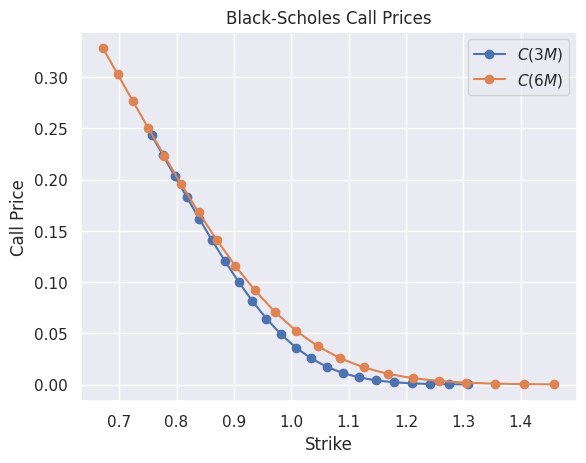

In [4]:
num_maturities = 2
num_strikes = 22
delta = 3
tau = np.array([0.25, 0.5])
sigma = 0.2

atm_iv = sigma*np.ones(num_maturities)

k = jordinson_scaling(atm_iv, tau[:, None], num_strikes, delta).T
t = tau.repeat(num_strikes).reshape(num_maturities, -1)
C = bs.price(1, k, t, sigma)

plt.plot(k[0], C[0], "-o", label=r"$C(3M)$")
plt.plot(k[1], C[1], "-o", label=r"$C(6M)$")

plt.xlabel("Strike")
plt.ylabel("Call Price")
plt.title("Black-Scholes Call Prices")

plt.legend()
plt.show()

### Calibrate discrete local volatilities

In [5]:
bounds = np.zeros([num_maturities, 2])
bounds[:, 0] = 0.1
bounds[:, 1] = 2.5

dlv = gm.dlv.DiscreteLocalVolatilityModel()
dlv.calibrate(
    prices=C.flatten(),
    strikes=k.flatten(),
    maturities=t.flatten(), 
    bounds=bounds, 
)

### Interpolated Densities

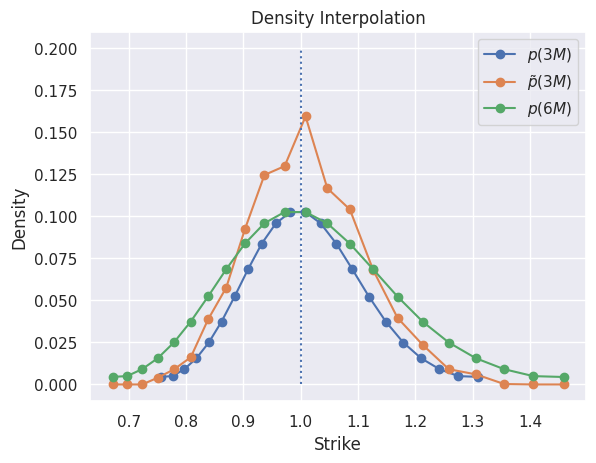

In [6]:
s_3m = dlv.slices[1]

p_3m = s_3m.density
p_3m_tilde = s_3m.psi@s_3m.omega@p_3m
p_6m = s_3m.transition_op(0.5)@p_3m

plt.plot(s_3m.k[2:-2], p_3m[1:-1], "-o", label=r"$p(3M)$")
plt.plot(s_3m.k_next[2:-2], p_3m_tilde[1:-1], "-o", label=r"$\tilde{p}(3M)$")
plt.plot(s_3m.k_next[2:-2], p_6m[1:-1], "-o", label=r"$p(6M)$")

plt.vlines(1, 0, 0.2, linestyles="dotted")

plt.legend()

plt.xlabel("Strike")
plt.ylabel("Density")
plt.title("Density Interpolation")
plt.show()

### Interpolated Call Prices

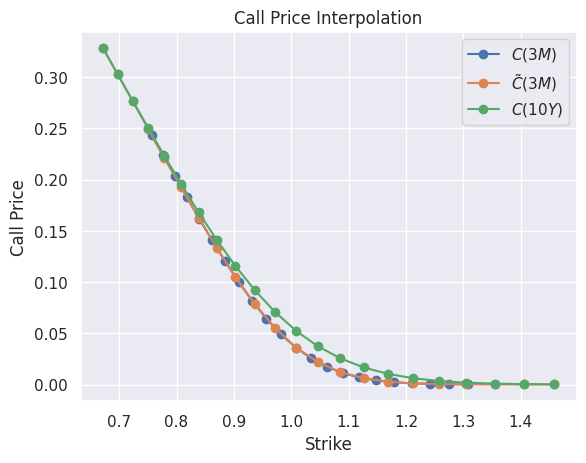

In [15]:
t_ =  np.concatenate([t[0, None], t[0, None], t[1, None]], axis=0)
k_ = np.concatenate([k[0, None], k[1, None],k[1, None]], axis=0)
prices_interpolated = dlv.get_prices(k_.flatten(), t_.flatten()).reshape(3, -1)

plt.plot(k_[0], prices_interpolated[0], "-o", label=r"$C(3M)$")
plt.plot(k_[1], prices_interpolated[1], "-o", label=r"$\tilde{C}(3M)$")
plt.plot(k_[2], prices_interpolated[2], "-o", label=r"$C(10Y)$")
plt.legend()

plt.xlabel("Strike")
plt.ylabel("Call Price")
plt.title("Call Price Interpolation")
plt.show()

### Transition Kernel (3m -> 6m)

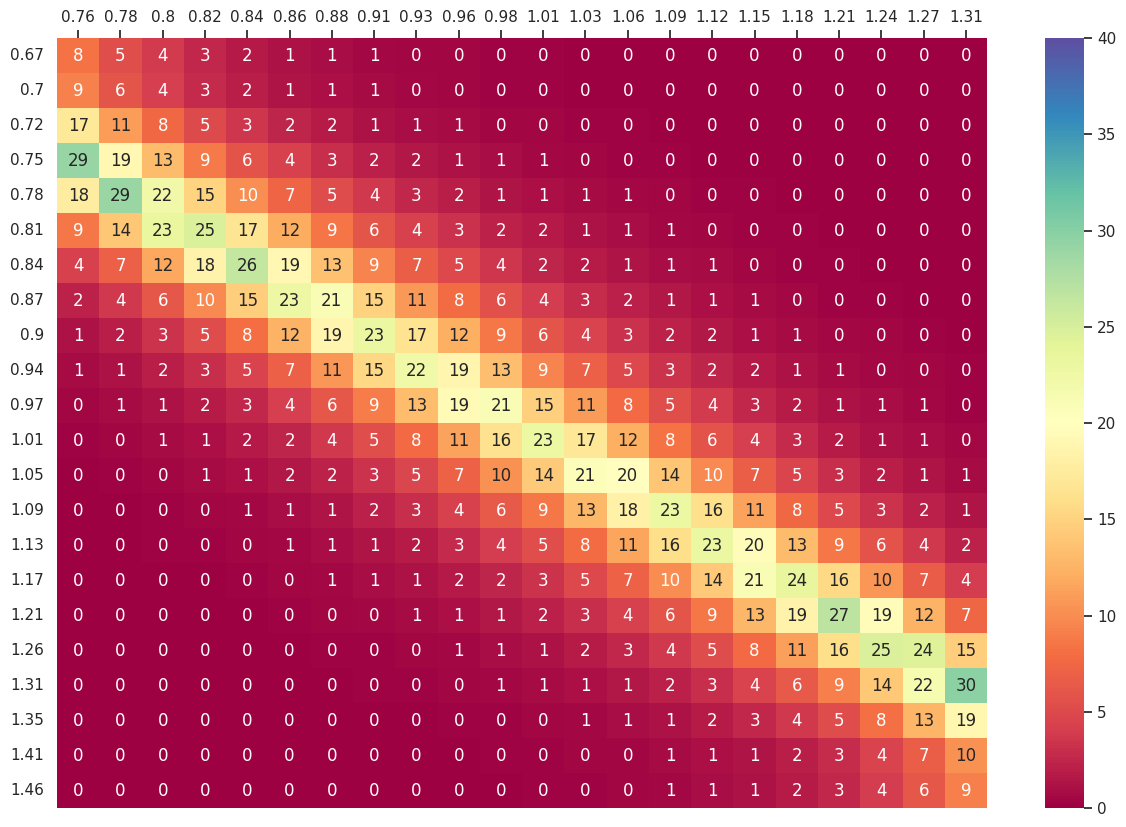

In [8]:
pi = s_3m.transition_op(0.5)

transition = pd.DataFrame(
    pi[1:-1, 1:-1], 
    columns=s_3m.k[2:-2].round(2), 
    index=s_3m.k_next[2:-2].round(2)
)

plt.subplots(figsize=(15,10))

ax = sns.heatmap(
    100*transition, 
    vmin=0,
    vmax=40,
    cmap=sns.color_palette("Spectral", as_cmap=True),
    annot=True,
    fmt=".0f"
)
ax.tick_params(axis="y", rotation=0)
ax.xaxis.tick_top()